In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fears.population import Population
from fears.utils import pharm

options = {
    'mut_rate':0.5*10**-8,
    'fitness_data':'from_file',
    'use_carrying_cap':True,
    'carrying_cap':10**8,
    'dwell':True,
    'dwell_time':24*2,
    'death_model':'pharmacodynamic',
    'n_timestep':300,
    'plot':False,
    'regimen_length':7*24,
    'max_dose':50,
    'dose_schedule':8,
    'n_sims':1,
    'curve_type':'pulsed'
}

p = Population(**options)

# tmax = np.linspace(1,20,5)
# thalf = np.linspace(1,20,5)
tmax = np.array([1,5,10,15,20])
thalf = np.array([1,5,10,15,20])

p_forget = np.linspace(0,0.8,5)

res = np.zeros((len(tmax),len(thalf),len(p_forget)))

# fig,ax = plt.subplots()

for i,tm in enumerate(tmax):
    for j,th in enumerate(thalf):
        ka,ke = pharm.est_pharm_params(th,tm)

        for k,pf in enumerate(p_forget):
            for sim in range(100):
                p.reset_drug_conc_curve(k_elim=ke,k_abs=ka,prob_drop=pf)

                counts,et = p.simulate()

                if np.sum(counts[-1]) < 1:
                    res[i,j,k] += 1



In [9]:
res = res/100

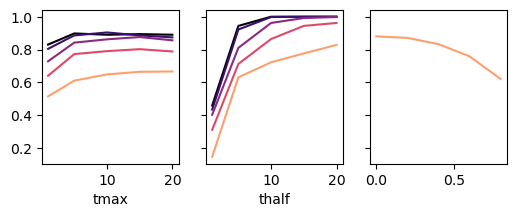

In [10]:
cmap = plt.get_cmap('magma')

# res dimensions: tmax, thalf, p_forget

fig,ax_list = plt.subplots(ncols=3,figsize=(6,2),sharey=True)

for i,p in enumerate(p_forget):

    ax = ax_list[0]

    ax.plot(tmax,res[:,:,i].mean(axis=1),label=p,c=cmap(i/len(p_forget)))

    ax.set_xlabel('tmax')

    ax = ax_list[1]

    ax.plot(thalf,res[:,:,i].mean(axis=0),label=p,c=cmap(i/len(p_forget)))

    ax.set_xlabel('thalf')

ax = ax_list[2]

ax.plot(p_forget,res.mean(axis=(0,1)),label=p,c=cmap(i/(len(p_forget))))

# ax_list[0].legend(frameon=False)

In [11]:
vmin = 1
vmax = 0

for i in range(3):
    min = res.mean(axis=i).min()
    max = res.mean(axis=i).max()

    if min < vmin:
        vmin = min
    
    if max > vmax:
        vmax = max


/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_11441/3119721880.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


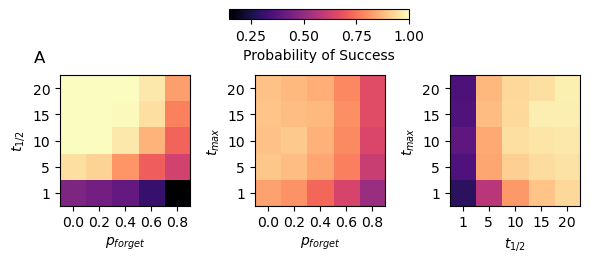

In [13]:
cmap = plt.get_cmap('viridis')

# res dimensions: tmax, thalf, p_forget
cmap = 'magma'

fig,ax_list = plt.subplots(ncols=3,figsize=(6,2))

ax = ax_list[0]
ax.imshow(res.mean(axis=0),cmap=cmap,origin='lower',vmin=vmin,vmax=vmax)

ax.set_yticks(np.arange(len(thalf)))
ax.set_yticklabels(thalf)

ax.set_xticks(np.arange(len(p_forget)))
ax.set_xticklabels(np.round(p_forget,1))

ax.set_ylabel('$t_{1/2}$')
ax.set_xlabel('$p_{forget}$')

ax = ax_list[1]
ax.imshow(res.mean(axis=1),cmap=cmap,origin='lower',vmin=vmin,vmax=vmax)

ax.set_yticks(np.arange(len(tmax)))
ax.set_yticklabels(tmax)

ax.set_xticks(np.arange(len(p_forget)))
ax.set_xticklabels(np.round(p_forget,1))

ax.set_ylabel('$t_{max}$')
ax.set_xlabel('$p_{forget}$')

ax = ax_list[2]
im = ax.imshow(res.mean(axis=2),cmap=cmap,origin='lower',vmin=vmin,vmax=vmax)

ax.set_yticks(np.arange(len(tmax)))
ax.set_yticklabels(tmax)

ax.set_xticks(np.arange(len(thalf)))
ax.set_xticklabels(thalf)

ax.set_ylabel('$t_{max}$')
ax.set_xlabel('$t_{1/2}$')

cbax = fig.add_axes([0.39, 1.2, 0.3, 0.05])
fig.colorbar(im, cax=cbax,orientation='horizontal',label='Probability of Success')

# cbax.set_xticks([0.4,0.6,0.8,1])

fig.tight_layout()

ax_list[0].annotate('A',(-0.2,1.1),xycoords='axes fraction',fontsize=12)

fig.savefig('../figures/nonadherence_sensitivity.pdf',bbox_inches='tight',dpi=400)

In [6]:
import statsmodels.api as sm

# normalize parameters

tmax_norm = (tmax - np.min(tmax))/(np.max(tmax) - np.min(tmax))
thalf_norm = (thalf - np.min(thalf))/(np.max(thalf) - np.min(thalf))
p_forget_norm = (p_forget - np.min(p_forget))/(np.max(p_forget) - np.min(p_forget))

X = np.array(np.meshgrid(tmax_norm,thalf_norm,p_forget_norm)).T.reshape(-1,3)

y = res.flatten()

model = sm.OLS(y,X).fit()

print(model.summary())



                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.886
Model:                            OLS   Adj. R-squared (uncentered):              0.884
Method:                 Least Squares   F-statistic:                              317.4
Date:                Mon, 29 Apr 2024   Prob (F-statistic):                    1.96e-57
Time:                        16:45:21   Log-Likelihood:                         -306.46
No. Observations:                 125   AIC:                                      618.9
Df Residuals:                     122   BIC:                                      627.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [7]:
X.shape

(125, 3)